# Megamean Visualizations

We examine connectome "megameans" for diffusion and functional MRI-derived connectomes. Visualizing adjacency matrices alongside coronal projections reveals connectome structure. For both the diffusion and functional data, the connectomes were computed using the Desikan parcellation and a graph of 70 vertices was obtained. Each vertex of the graph corresponds to a single Region of Interest (ROI) in the Desikan parcellation. The vertices are ordered:the first 35 vertices corresponding to ROIs in the left-hemisphere and the second 35 vertices corresponding to ROIs of the right-hemisphere.

#### Construction of the Diffusion Megamean Graph

DWI connectomes were acquired from 2,861 scans from approximately 1,613 subjects across 12 scanning sites for the Desikan parcellation using the NDMG-d pipeline. Connectome statistics were performed by taking the edge-wise mean fiber count over all connectomes in the cohort and reporting the resulting graph as the "megamean" diffusion connectome. 

#### Construction of the Functional Megamean Graph

fMRI connectomes were acquired from 1,709 scans from approximately 813 subjects across 18 scanning sites for the Desikan parcellation using the NDMG-f pipeline. Connectome statistics were performed by taking the edge-wise mean fiber count over all connectomes in the cohort and reporting the resulting graph as the "megamean" fMRI connectome.


#### Import libraries for processing and visualization. 
These are a mix of standard numerical and network libraries and also some neuroscience specific libraries, such as nilearn and nibabel.


In [3]:
import networkx as nx
import nilearn as ni
import numpy as np
import nibabel as nb
from nilearn import plotting as nip
from nilearn import image
from nilearn import input_data
from nilearn.regions import connected_label_regions
import matplotlib.pyplot as plt
%matplotlib inline

#### Visualize the Desikan atlas.

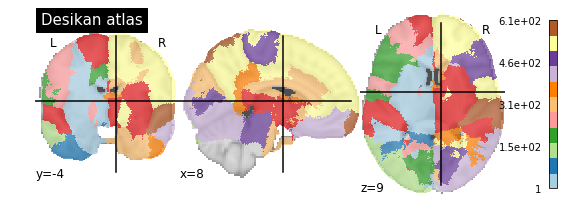

In [4]:
from nilearn import datasets
from nilearn.regions import connected_label_regions
des = '../input/desikan_res-1x1x1.nii.gz'
desim = nb.load(des)
desim = nb.Nifti1Image(affine=desim.affine, header=desim.header, dataobj=desim.get_data())

reg = connected_label_regions(desim)
desikan = nip.plot_roi(reg, title='Desikan atlas',
            cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')
desikan.savefig('../output/Desikan_Atlas')

#### Read input data and construct the graphs
The first data import is for the diffusion data for the 2,861 scans from the approximately 1,613 subjects. The second data import is for the functional data, coming from 1,709 scans from approximately 813 subjects.

The region identifiers are consistent across both of the graphs so that `sorted_nodes` can be used to correlate regions among the DWI and fMRI graphs and Desikan atlas.

In [5]:
dwi_megamean_graph = nx.read_weighted_edgelist('../input/dwimean_2861.edgelist')
nodes = dwi_megamean_graph.nodes()
sort_id = np.argsort(np.array(nodes).astype(int))
sorted_nodes = np.array(nodes)[sort_id]

dwi_megamean_mtx = nx.to_numpy_matrix(dwi_megamean_graph, nodelist=sorted_nodes)
fmri_megamean_graph = nx.read_weighted_edgelist('../input/fmrimean_1709.edgelist')
fmri_megamean_mtx = nx.to_numpy_matrix(fmri_megamean_graph, nodelist=sorted_nodes)

In [6]:
des_dat = desim.get_data()
labs = np.unique(des_dat)
labs = labs[labs != 0]
des_4ddat = np.stack([np.asarray(des_dat == lab).astype('float64') for lab in labs], axis=3)
des_parcels = nb.Nifti1Image(dataobj=des_4ddat, header=desim.header, affine=desim.affine)

Next, we calculate the 3d coordinates of our ROIs:

In [7]:
regions_imgs = image.iter_img(des_parcels)
coords_connectome = [nip.find_xyz_cut_coords(img) for img in regions_imgs]

# Diffusion Connectome

## Adjacency Matrix

The most common visualization presents the diffusion connectome as an adjacency matrix with higher values in the upper-left and lower-right quadrants indicating more connectivity within the left and right hemisphere respectively.

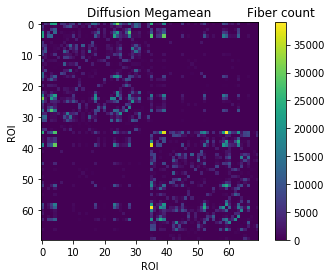

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(dwi_megamean_mtx)
ax.set_xlabel('ROI')
ax.set_ylabel('ROI')
ax.set_title('Diffusion Megamean')
cbar = fig.colorbar(cax)
cbar.ax.set_title('Fiber count')
plt.savefig('../output/Fiber_count')

## Coronal Projection

Below, we threshold the top $80%$ of edges and visualize the 2-d projection of the adjacency graph in a coronal slice in real brain space (in which position is determined by location of the ROI in the MNI152 template atlas). The three charts show the top $80%$ of edges (top), the top $80%$ of edges within each hemisphere (middle), and the top $80%$ of edges across hemispheres (bottom).

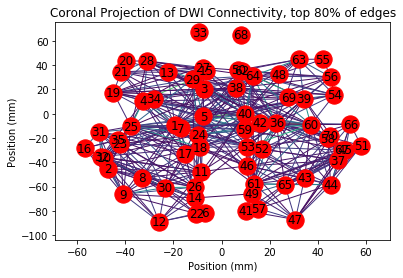

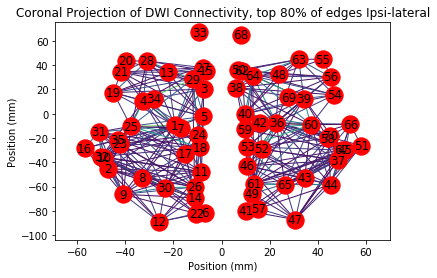

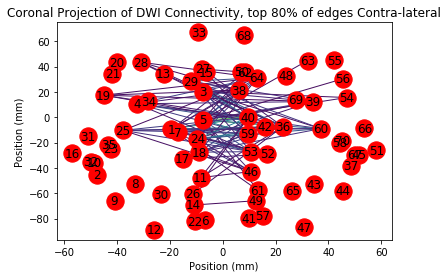

In [9]:
import copy
coords = {}
for lab, coord in zip(sorted_nodes, coords_connectome):
    coords[lab] = coord[:2]
dwi = copy.deepcopy(dwi_megamean_graph)
for u, v, d in list(dwi.edges(data='weight')):
    if d < np.percentile(dwi_megamean_mtx, 80):
        dwi.remove_edge(u, v)
        
edges = [d for u, v, d in dwi.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(dwi, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of DWI Connectivity, top 80% of edges')
plt.savefig('../output/Coronal Projection of DWI Connectivity - top 80% of edges')


dwi = copy.deepcopy(dwi_megamean_graph)
for u, v, d in list(dwi.edges(data='weight')):
    if d < np.percentile(dwi_megamean_mtx, 80) or ((int(u) <= 35 and int(v) > 35) or (int(u) > 35 and int(v) <= 35)):
        dwi.remove_edge(u, v)
        
edges = [d for u, v, d in dwi.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(dwi, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of DWI Connectivity, top 80% of edges Ipsi-lateral')
plt.savefig('../output/Coronal Projection of DWI Connectivity, top 80% of edges Ipsi-lateral')

dwi = copy.deepcopy(dwi_megamean_graph)
for u, v, d in list(dwi.edges(data='weight')):
    if d < np.percentile(dwi_megamean_mtx, 80) or ((int(u) <= 35 and int(v) <= 35) or (int(u) > 35 and int(v) > 35)):
        dwi.remove_edge(u, v)
        
edges = [d for u, v, d in dwi.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(dwi, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of DWI Connectivity, top 80% of edges Contra-lateral')
plt.savefig('../output/Coronal Projection of DWI Connectivity, top 80% of edges Contra-lateral')

The majority of the top $80%$ of edges occur ipsi-laterally, and contra-lateral connections are mainly prevalent between regions directly adjacent the corpus callosum. This matches intuition for structural DWI connectomes.

# Functional Connectome

## Adjacency Matrix

We look at the functional connectome as an adjacency matrix also and obserce that it has more correlated structure across hemispheres (upper-right and bottom-left).

Text(0.5,1,'Rank')

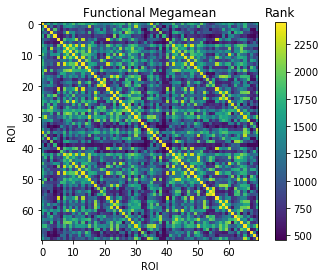

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(fmri_megamean_mtx)
ax.set_xlabel('ROI')
ax.set_ylabel('ROI')
ax.set_title('Functional Megamean')
cbar = fig.colorbar(cax)
cbar.ax.set_title('Rank')

## Coronal Projection

We repeat the same process to visualize the functional connectome as a graph, retaining the top-$80%$ of edges for the whole brain, within hemisphere, and across hemispheres. 

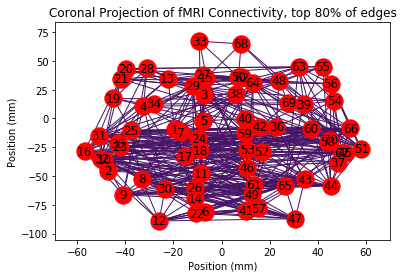

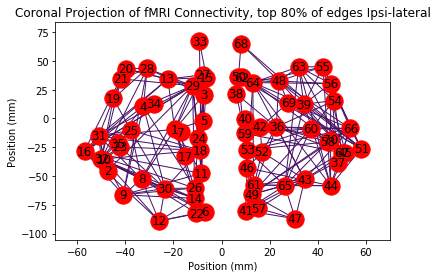

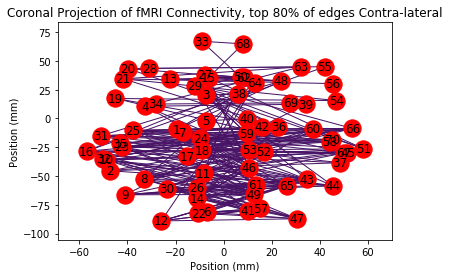

In [11]:
import copy
coords = {}
for lab, coord in zip(sorted_nodes, coords_connectome):
    coords[lab] = coord[:2]
fmri = copy.deepcopy(fmri_megamean_graph)
for u, v, d in list(fmri.edges(data='weight')):
    if d < np.percentile(fmri_megamean_mtx, 80):
        fmri.remove_edge(u, v)
        
edges = [d for u, v, d in fmri.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(fmri, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of fMRI Connectivity, top 80% of edges')
plt.savefig('../output/Coronal Projection of fMRI Connectivity, top 80% of edges')

fmri = copy.deepcopy(fmri_megamean_graph)
for u, v, d in list(fmri.edges(data='weight')):
    if d < np.percentile(fmri_megamean_mtx, 80) or ((int(u) <= 35 and int(v) > 35) or (int(u) > 35 and int(v) <= 35)):
        fmri.remove_edge(u, v)
        
edges = [d for u, v, d in fmri.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(fmri, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of fMRI Connectivity, top 80% of edges Ipsi-lateral')
plt.savefig('../output/Coronal Projection of fMRI Connectivity, top 80% of edges Ipsi-lateral')

fmri = copy.deepcopy(fmri_megamean_graph)
for u, v, d in list(fmri.edges(data='weight')):
    if d < np.percentile(fmri_megamean_mtx, 80) or ((int(u) <= 35 and int(v) <= 35) or (int(u) > 35 and int(v) > 35)):
        fmri.remove_edge(u, v)
        
edges = [d for u, v, d in fmri.edges(data='weight')]
cmap = plt.cm.Purples
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw_networkx(fmri, ax=ax, pos=coords, cmap=my_cmap, edge_color=edges, edge_vmin=0, edge_vmax=np.max(dwi_megamean_mtx))
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Position (mm)')
ax.set_title('Coronal Projection of fMRI Connectivity, top 80% of edges Contra-lateral')
plt.savefig('../output/Coronal Projection of fMRI Connectivity, top 80% of edges Contra-lateral')

Looking at the graphs in brain space when compared with the diffusion connectomes confirms that functional connectomes exhibit far less hemispheric separation. There are more contra-lateral connections (across hemisphere) and from a larger diversity of brain regions.  The "bilateral" appearance of the brain graph shows that corresponding brain regions in left and right hemisphere are correlated and activate together.